<center>Uvod u umjetnu inteligenciju, Arhitekture neuronskih mreža </center>
<h1><center>Klasifikacija sentimenta korištenjem povratnih neuronskih mreža</center></h1>
<center>Ivona Grbeša Dragun</center>

Dataset: https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset

#### **Učitavanje podataka**

In [ ]:
pip install pydataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pydataset: filename=pydataset-0.2.0-py3-none-any.whl size=15939432 sha256=2af17475528233a6905b77bae0fe44001b5a65a87cd5e70a252a46be7fdfdc37
  Stored in directory: /root/.cache/pip/wheels/d7/e5/36/85d319586b4a405d001029d489102f526ce5546248c295932a
Successfully built pydataset


In [ ]:
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

In [ ]:
from keras.layers import Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import pickle
import json

initiated datasets repo at: /root/.pydataset/


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences #Pads sequences to the same length

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, GRU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# tSNE projekcije embeddinga
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ANM/uui-anm-projekt

/content/drive/MyDrive/ANM/uui-anm-projekt


In [ ]:
df=pd.read_csv("twitter_sentiment_data.csv")

Postavimo labele s opisom

In [ ]:
label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"]) #dataframe s labelama i opisima

In [ ]:
labelDf

,label,name,description
0,-1,Anti,the tweet does not believe in man-made climate change
1,0,Neutral,the tweet neither supports nor refutes the belief of man-made climate change
2,1,Pro,the tweet supports the belief of man-made climate change
3,2,News,the tweet links to factual news about climate change


Uvid u dataset

In [ ]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [ ]:
df.shape

(43943, 3)

In [ ]:
len(df[df.message == None]) #nema praznih vrijednosti

0

In [ ]:
df.isna().sum() # laksa provjera NaN

sentiment    0
message      0
tweetid      0
dtype: int64

In [ ]:
df.sentiment.value_counts() #koliko ima kojih sentimenata

 1    22962
 2     9276
 0     7715
-1     3990
Name: sentiment, dtype: int64

Vektorizacijom transformiramo tekst u brojeve. Izdvojimo prvo stupac message u kojem se nalaze tekstovi.

In [ ]:
dfTweets = df["message"]

In [ ]:
dfTweets.head()

0    @tiniebeany climate change is an interesting hustle as it was global warming but the p...
1    RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...
2    Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...
3    RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...
4    RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...
Name: message, dtype: object

In [ ]:
type(dfTweets)

pandas.core.series.Series

Svaku poruku razdvojimo u niz riječi malim slovima bez interpunkcije (tokenizacija). Metoda prima niz tekstova, a vraća niz riječi.
RegexpTokenizer razdvaja string koristeći regularne izraze (ovdje je separator \w+).

In [ ]:
def createTokenizedArray(sentences):

    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence) #words je niz

        # Append word array to list.
        tokenizedArray.append(words) #ovo ce biti niz nizova

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [ ]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5]) #prvih 5 tweetova tokenizirano, nakon toga castali u Series

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4    [rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec...
dtype: object

Iz svakog tokeniziranog niza želimo izbaciti interpunkciju ili stop words (koje ne daju nikakvo novo značenje).

In [ ]:
def removeStopWords(tokenList):
    stopWords = set(stopwords.words('english'))
    shorterSentences = []  #prazni niz za nove recenice

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:

                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if (len(word) > 1 and word.isdigit() == False):
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

In [ ]:
# nad tokeniziranom listom tokenizedLi pozovemo metodu za uklanjanje stop words
# novu listu u kojoj nema stopwords spremamo u tokenizedNoStopLi
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Prije uklanjanja stop words:\n{tokenizedLi[10]}")
print(f"Nakon uklanjanja stop words:\n{tokenizedNoStopLi[10]}")

Prije uklanjanja stop words:
['rt', 'drdejarnett', 'it', 's', 'vital', 'that', 'the', 'public', 'health', 'community', 'addresses', 'climate', 'change', 'via', 'climate4health', 's', 'tabola', 'apha2016', 'https', 't', 'co', 'ã', 'â', 'â']
Nakon uklanjanja stop words:
['rt', 'drdejarnett', 'vital', 'public', 'health', 'community', 'addresses', 'climate', 'change', 'via', 'climate4health', 'tabola', 'apha2016', 'https', 'co']


In [ ]:
print(len(tokenizedLi[10]))
print(len(tokenizedNoStopLi[10]))

24
15


Stemming je uklanjanje sufiksa s riječi koje imaju zajednički korijen. Na taj način poboljšava se algoritam za analizu sentimenta.
Metoda za stemming primat će listu rečenica, a vraćati listu rečenica bez sufiksa.

In [ ]:
def stemWords(sentenceArrays):

    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # prazni niz rijeci za svaku recenicu
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # "stemmamo" svaku rijec iz recenice (maknemo joj eventualni sufiks, višak i sl.) i stavimo u novi niz

        # Convert array back to sentence of stemmed words.
        delimeter = ' '
        sentence = delimeter.join(stemmedArray) #niz stemmanih rijeci spojimo u 1 recenicu

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences
    #vraca se niz stemmanih recenica

In [ ]:
# metodi za stemmanje posaljemo niz tokeniziranih rijeci bez stop rijeci
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


In [ ]:
print(len(tokenizedNoStopLi[0]))
print(len(stemmedLi[0].split()))
# isti broj rijeci ali su izmijenjene/skracene, uklonjeni su sufiksi

13
13


#### **Vektorizacija**

In [ ]:
# stvaramo matricu s vektorima rijeci
# i jos vracamo dictionary sa svim rijecima koje koristimo

Napravit ćemo sami token_index rječnik, po uzoru s vježbi index2word.

In [ ]:
token_index = {}

for tekst in stemmedLi:
  for rijec in text_to_word_sequence(tekst):
    if rijec not in token_index:
      # indeks 0 ne koristimo niti za jednu rijec
      token_index[rijec] = len(token_index) + 1

In [ ]:
len(token_index) # imamo ovoliko jedinstvenih

67063

In [ ]:
def encode_word_tokens(tekst):
  return [token_index[token] for token in text_to_word_sequence(tekst)]

In [ ]:
corpus_embedded = [encode_word_tokens(tekst) for tekst in stemmedLi]
#corpus_embedded

#svaku recenicu u stemmanoj listi kodiraj u brojeve

In [ ]:
corpus_embedded[0]  #prva (nulta) recenica kodirana u brojeve

[1, 2, 3, 4, 5, 6, 7, 8, 9, 7, 10, 11, 12]

In [ ]:
br_rijeci = lambda text: len(text_to_word_sequence(text))
najdulji_tekst = max(stemmedLi, key = br_rijeci) # nademo najdulji tekst
max_d = br_rijeci(najdulji_tekst)

print(f'Max br rijeci: {max_d} ({najdulji_tekst})') # ima cudnih znakova! ovo bi trebalo izbaciti u procesiranju ako zelimo bolje rezultate

Max br rijeci: 46 (rt hopenivers âµã âª global warm žã â¹ë â¹â šã â¹â â²ã â²ã â¹ë â²ã â¹æ â¹â ¹ã â¹â â² â¹â â¹â žã âµã â¹â â¹â šã â¹â šã â¹â â¹ï â¹â â¹ï ºã â¹â žã ºã â¹â â¹æ â¹â â²ã â¹â âµã http co xqã)


In [ ]:
#postavimo da je duljina do koje nadopunjavamo = maksimalnoj duljini, tj. 46
padded_corpus = pad_sequences(corpus_embedded, max_d, padding='post')
print(padded_corpus)

[[    1     2     3 ...     0     0     0]
 [   13    14    15 ...     0     0     0]
 [   26    27    28 ...     0     0     0]
 ...
 [   13 67061   318 ...     0     0     0]
 [   13  2120   335 ...     0     0     0]
 [67063 10705  5134 ...     0     0     0]]


In [ ]:
np.max(padded_corpus) # ovoliko jedinstvenih rijeci u rjecniku

67063

In [ ]:
print(padded_corpus.shape)

(43943, 46)


In [ ]:
vocab_size = 67063+1 # np.max(padded_corpus)
max_len = 46 # padded_corpus.shape[1]

### Modeli

In [ ]:
sentiments = df.sentiment

In [ ]:
sentiments = sentiments.map(lambda x: 3 if x==-1 else x) # makli -1 i stavili 3 umjesto toga

In [ ]:
sentiments.value_counts() #sad su sve vrijednosti 0,1,2 ili 3

1    22962
2     9276
0     7715
3     3990
Name: sentiment, dtype: int64

In [ ]:
# 75% skup za treniranje, 25% skup za testiranje
X_train, X_test, y_train, y_test = train_test_split(padded_corpus, sentiments, test_size=0.25, random_state=2)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

32957
10986
32957
10986


In [ ]:
br_epoha=10
batch_size=128

Definiramo metode za ispis i crtanje grafova koje ćemo koristiti u svim modelima.

In [ ]:
def print_acc(model): #metoda za ispis tocnosti, prima model
    _, acc = model.evaluate(X_test, y_test, verbose = 0) #evaluira ga na skupu za testiranje
    print('Accuracy on test data: {:.2f} %'.format(acc*100)) #ispisuje njegovu tocnost kao postotak

In [ ]:
def plot_history(hist_baseline, br_epoha): # metoda za crtanje krivulja tocnosti i gubitka

    fig = plt.figure(figsize = (17,5))
    metrics = ["loss", "accuracy"]

    for i in range(len(metrics)):
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric)
        plt.plot(range(1, br_epoha + 1), hist_baseline.history[metric], 'o-',
                 label="train", color = "tab:blue") #training set-plavo
        plt.plot(range(1, br_epoha + 1), hist_baseline.history["val_" + metric], 'o-',
                 label="val", color = "tab:orange") #test set-narancasto

        plt.legend()

In [ ]:
def plot_history2(hist_baseline, hist_regularized = None):

    fig = plt.figure(figsize = (17,5))
    metrics = ["loss", "accuracy"]

    for i in range(len(metrics)): #za svaku od metrika
        metric = metrics[i]
        plt.subplot(1, 2, i+1)
        plt.title(metric.capitalize())
        plt.xlabel("epoha")
        plt.ylabel(metric) #na y-osi je tocna vrij.metrike u danoj epohi
        br_epoha = len(hist_baseline.history[metric])
        plt.plot(range(1, br_epoha + 1), hist_baseline.history[metric],
                 label="train", color = "tab:blue")
        plt.plot(range(1, br_epoha + 1), hist_baseline.history["val_" + metric],
                 label="val", color = "tab:orange")

        if hist_regularized:
            br_epoha = len(hist_regularized.history[metric])
            plt.plot(range(1, br_epoha + 1), hist_regularized.history[metric],
                 label="regularized train", color = "tab:blue", linestyle = '--')
            plt.plot(range(1, br_epoha + 1), hist_regularized.history["val_" + metric],
                 label="regularized val", color = "tab:orange", linestyle = '--')
        plt.legend()




Sve modele za početak sam trenirala u 10 epoha s batch size 128 i koristeći dropout za dobivanje boljih rezultata. (Svaka od ove 4 mreže dala je bolje rezultate korištenjem dropouta nego bez dropouta pa sam zadržala taj sloj u svakom od modela.) Zatim sam svaku od mreža evaluirala na skupu za testiranje te iz toga dobila točnost na testnim podacima i nacrtala krivulje točnosti i gubitka.
Od sve 4 mreže izabrat ću one koje pokazuju najbolje rezultate i njih dodatno analizirati da bi vidjela kako se ponašaju kad mijenjamo hiperparametre, kakva predviđanja daju i možemo li ih dodatno poboljšati.

####**Simple RNN**


Za različite dropout rates 0.2, 0.3, 0.4, 0.5 redom, dobiju se otprilike sljedeće točnosti na skupu za testiranje: 61.60%, 62.52%, 63.52%, 63.32%. Zbog toga sam izabrala dropout rate 0.4 jer najbolje optimizira problem.

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=128,
                    input_length=max_len))
model.add(SimpleRNN(128))
model.add(Dropout(0.4)) #ovo je opcionalno
model.add(Dense(4, activation='softmax')) # imamo 4 klase...

#cp = ModelCheckpoint('model', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') #dodamo checkpoint

model.compile(loss='sparse_categorical_crossentropy', # ... ne dvije! Nije binarna klasifikacija, pa nije ni binary loss.
              optimizer='adam',
              metrics=['accuracy'])

Sada iskoristimo Embedding sloj za učenje. Mi smo svakoj riječi pridružili broj i sada koristimo Embedding sloj kako bismo imali smislene ulaze u ostatak mreže. Dakle, zapravo pomoću ovog sloja učimo vektorske reprezentacije riječi.

In [ ]:
history=model.fit(X_train, y_train,
                  epochs=br_epoha,
                  batch_size=batch_size,
                  validation_split=0.2)

Epoch 1/5
206/206 [==============================] - 55s 255ms/step - loss: 0.9898 - accuracy: 0.5953 - val_loss: 0.8211 - val_accuracy: 0.6620
Epoch 2/5
206/206 [==============================] - 55s 266ms/step - loss: 0.5291 - accuracy: 0.8024 - val_loss: 0.8936 - val_accuracy: 0.6634
Epoch 3/5
206/206 [==============================] - 54s 263ms/step - loss: 0.1865 - accuracy: 0.9402 - val_loss: 1.0679 - val_accuracy: 0.6330
Epoch 4/5
206/206 [==============================] - 54s 262ms/step - loss: 0.0676 - accuracy: 0.9802 - val_loss: 1.2409 - val_accuracy: 0.6566
Epoch 5/5
206/206 [==============================] - 53s 257ms/step - loss: 0.0346 - accuracy: 0.9903 - val_loss: 1.3925 - val_accuracy: 0.6455


In [ ]:
print_acc(model)

Accuracy on test data: 64.03 %


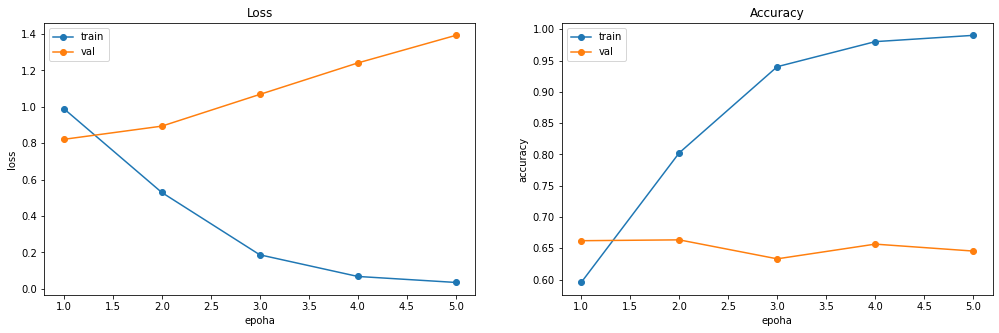

In [ ]:
plot_history(history, br_epoha)

Iz krivulja točnosti i gubitka uočavamo da je došlo do overfittinga i to već u prve 2-3 epohe, nakon čega se na skupu za treniranje točnost povećava do gotovo 100% i gubitak pada do 0%, dok na skupu za validaciju nisu tako dobri rezultati: pomoću checkpointa vidimo da točnost maksimalno ide do 67%, a gubitak čak do 175%.

####**LSTM**

**Treniranje i evaluacija**

Za različite dropout rates 0.2, 0.3, 0.4, 0.5 redom, dobiju se otprilike sljedeće točnosti na skupu za testiranje: 64.75%, 66.98%, 64.59%, 63.47%. Zbog toga sam izabrala dropout rate 0.3 jer najbolje optimizira problem.

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=vocab_size,
                         output_dim=128,
                         input_length=max_len))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dropout(0.3)) #ovo je opcionalno
model_LSTM.add(Dense(4, activation='softmax'))
#cp = ModelCheckpoint('model_LSTM/', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') #dodamo checkpoint

model_LSTM.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_LSTM.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 46, 128)           8584192   
                                                                 
 lstm_9 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516       
                                                                 
Total params: 8,716,292
Trainable params: 8,716,292
Non-trainable params: 0
_________________________________________________________________


In [ ]:
br_epoha=10
batch_size=128
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
206/206 [==============================] - 4s 14ms/step - loss: 1.2019 - accuracy: 0.5201 - val_loss: 1.1840 - val_accuracy: 0.5306
Epoch 2/10
206/206 [==============================] - 2s 12ms/step - loss: 1.1961 - accuracy: 0.5217 - val_loss: 1.1831 - val_accuracy: 0.5306
Epoch 3/10
206/206 [==============================] - 3s 14ms/step - loss: 1.1950 - accuracy: 0.5217 - val_loss: 1.1831 - val_accuracy: 0.5306
Epoch 4/10
206/206 [==============================] - 3s 13ms/step - loss: 1.1953 - accuracy: 0.5217 - val_loss: 1.1835 - val_accuracy: 0.5306
Epoch 5/10
206/206 [==============================] - 3s 12ms/step - loss: 1.1944 - accuracy: 0.5217 - val_loss: 1.1837 - val_accuracy: 0.5306
Epoch 6/10
206/206 [==============================] - 2s 12ms/step - loss: 1.1951 - accuracy: 0.5217 - val_loss: 1.1829 - val_accuracy: 0.5306
Epoch 7/10
206/206 [==============================] - 3s 12ms/step - loss: 1.1946 - accuracy: 0.5217 - val_loss: 1.1827 - val_accuracy: 0.5306

In [ ]:
print_acc(model_LSTM) # malo bolja točnost od SimpleRNN modela

Accuracy on test data: 51.97 %


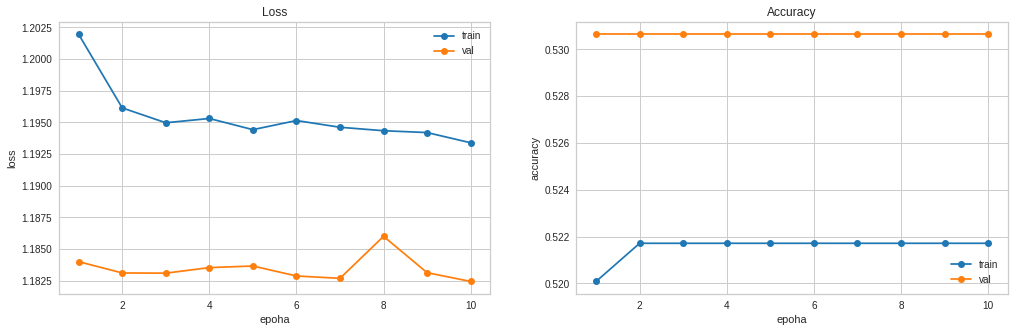

In [ ]:
plot_history(history_LSTM, br_epoha)

Iz grafova se uočava overfitting, no za razliku od SimpleRNN modela, overfitting se događa nekoliko epoha kasnije i manje je drastična razlika između točnosti na skupu za treniranje i skupu za validaciju. Točnost na skupu za validaciju veća nego u prethodnom modelu i ne pada naglo, raste do 2.epohe a zatim se kreće oko 0.7 uz manje promjene. Kod funkcije gubitka više se uočava overfitting, s obzirom da gubitak na skupu za treniranje pada sve do 0, dok na skupu za validaciju stalno raste.

Očekivano, uspoređujući i same točnosti na skupu za testiranje, LSTM daje bolje rezultate (točnost oko 67%) nego SimpleRNN (točnost oko 63%).

**Predviđanje na skupu za testiranje i matrica konfuzije**

In [ ]:
y_test_pred=model_LSTM.predict(X_test)
# stvarne vrijednosti su y_test

344/344 [==============================] - 17s 45ms/step


In [ ]:
y_test_pred = [np.argmax(x) for x in y_test_pred]

Text(0.5, 1.0, 'Predviđanje LSTM modelom')

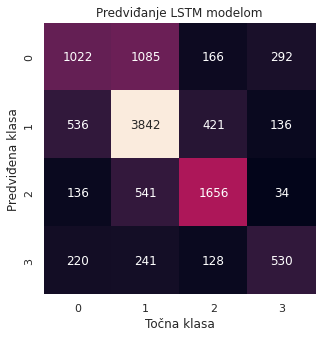

In [ ]:
mat = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize = (5,5))
sns.set(font_scale=1) # malo veći font
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Točna klasa')
plt.ylabel('Predviđena klasa')
plt.title('Predviđanje LSTM modelom')

In [ ]:
# koliko ih je tocno razvrstanih (odn. dijagonalnih)
ukupno=len(y_test)
tocno=mat[0][0]+mat[1][1]+mat[2][2]+mat[3][3]
print("Tocno razvrstanih je {:.2f} ".format(tocno/ukupno))

Tocno razvrstanih je 0.64 


**Prikaz netočno klasificiranih primjera iz skupa za testiranje**

In [ ]:
y_test_pred[:10] #prvih 10 predviđanja

[1, 0, 1, 0, 1, 3, 1, 1, 2, 1]

In [ ]:
# krivo klasificirani
krivo = [tekst  for (tekst, pred, labela) in zip(X_test, y_test_pred, y_test) if y_test_pred != labela]

In [ ]:
print(krivo[0]) #zanima nas koje su ovo rijeci

[   13  7988  1342    20   964  1280   586     2     3    22    23 11597
    32   350     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]


In [ ]:
tocne_vrij=np.array(y_test)
print(tocne_vrij) # y_test pretvoren u niz za lakse pristupanje elementima

[1 1 1 ... 2 1 2]


Prikažimo prvih 10 krivo klasificiranih tweetova.

In [ ]:
# prvih 10 krivo klasificiranih tweetova zajedno s njihovim predviđenim i stvarnim klasama

br=0
for i in range(len(tocne_vrij)):
  if y_test_pred[i]!=tocne_vrij[i]: #ako je primjer krivo klasificiran
    br+=1
    if br<11: #ogranicenje da printamo samo prvih 10 krivo klasificiranih
      recenica=""
      for x in krivo[br]: #krivo klasificiranu recenicu prevodimo iz brojeva u rijeci
        if x!=0:
          recenica+=list(token_index.keys())[list(token_index.values()).index(x)]+" "
      print(br,".primjer: {}. Predviđeno: {}, točno: {}.".format(recenica, y_test_pred[i], tocne_vrij[i]))


1 .primjer: nycsouthpaw seagal lori admit climat chang insist wall built . Predviđeno: 0, točno: 1.
2 .primjer: rt wef cleverest countri climat chang learn http co q74byermpv apoliticalco http co iprã . Predviđeno: 0, točno: 1.
3 .primjer: rt somexlcan listen barack obama discuss climat chang make miss common sens cri http co edo9dixuzq . Predviđeno: 1, točno: 2.
4 .primjer: nytim request presid america posit climat chang . Predviđeno: 2, točno: 0.
5 .primjer: rt stevesgoddard climat scientist depend global warm scam research fund keep becom unemploy would anyâ . Predviđeno: 2, točno: 1.
6 .primjer: rt sethmacfarlan look america offici believ climat chang hoax sorri everybodi els . Predviđeno: 3, točno: 1.
7 .primjer: rt ezraklein donald trump tweet climat chang skeptic time http co te79u3uojj . Predviđeno: 3, točno: 1.
8 .primjer: rt feraliaga link climat chang diabet http co do5u5rkywu http co zh4y9fyo1i . Predviđeno: 0, točno: 2.
9 .primjer: rt siddarthpaim head epa made anoth dange

**Prilagođavanje hiperparametara**

In [ ]:
batch_size=64
br_epoha=10
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/10
412/412 [==============================] - 7s 13ms/step - loss: 1.2002 - accuracy: 0.5207 - val_loss: 1.1851 - val_accuracy: 0.5306
Epoch 2/10
412/412 [==============================] - 5s 12ms/step - loss: 1.1956 - accuracy: 0.5217 - val_loss: 1.1833 - val_accuracy: 0.5306
Epoch 3/10
412/412 [==============================] - 5s 11ms/step - loss: 1.1952 - accuracy: 0.5217 - val_loss: 1.1828 - val_accuracy: 0.5306
Epoch 4/10
412/412 [==============================] - 4s 11ms/step - loss: 1.1246 - accuracy: 0.5342 - val_loss: 0.9922 - val_accuracy: 0.5652
Epoch 5/10
412/412 [==============================] - 5s 13ms/step - loss: 0.8200 - accuracy: 0.6495 - val_loss: 0.8258 - val_accuracy: 0.6456
Epoch 6/10
412/412 [==============================] - 5s 11ms/step - loss: 0.4393 - accuracy: 0.8290 - val_loss: 0.8402 - val_accuracy: 0.6880
Epoch 7/10
412/412 [==============================] - 4s 11ms/step - loss: 0.1985 - accuracy: 0.9345 - val_loss: 1.0810 - val_accuracy: 0.6754

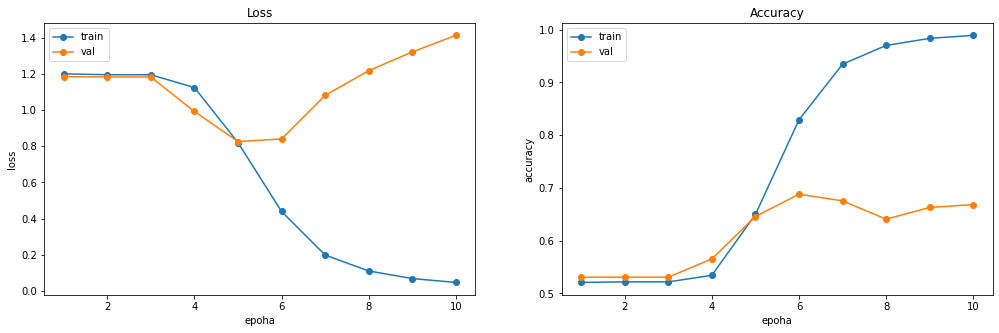

In [ ]:
plot_history(history_LSTM, br_epoha)

In [ ]:
batch_size=32
br_epoha=10
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/10
824/824 [==============================] - 12s 12ms/step - loss: 1.1993 - accuracy: 0.5211 - val_loss: 1.1844 - val_accuracy: 0.5306
Epoch 2/10
824/824 [==============================] - 9s 11ms/step - loss: 1.1962 - accuracy: 0.5217 - val_loss: 1.1849 - val_accuracy: 0.5306
Epoch 3/10
824/824 [==============================] - 9s 12ms/step - loss: 1.1948 - accuracy: 0.5217 - val_loss: 1.1835 - val_accuracy: 0.5306
Epoch 4/10
824/824 [==============================] - 9s 12ms/step - loss: 1.1953 - accuracy: 0.5217 - val_loss: 1.1844 - val_accuracy: 0.5306
Epoch 5/10
824/824 [==============================] - 10s 13ms/step - loss: 1.1943 - accuracy: 0.5217 - val_loss: 1.1830 - val_accuracy: 0.5306
Epoch 6/10
824/824 [==============================] - 10s 12ms/step - loss: 1.1943 - accuracy: 0.5217 - val_loss: 1.1825 - val_accuracy: 0.5306
Epoch 7/10
824/824 [==============================] - 9s 11ms/step - loss: 1.1942 - accuracy: 0.5217 - val_loss: 1.1834 - val_accuracy: 0.5

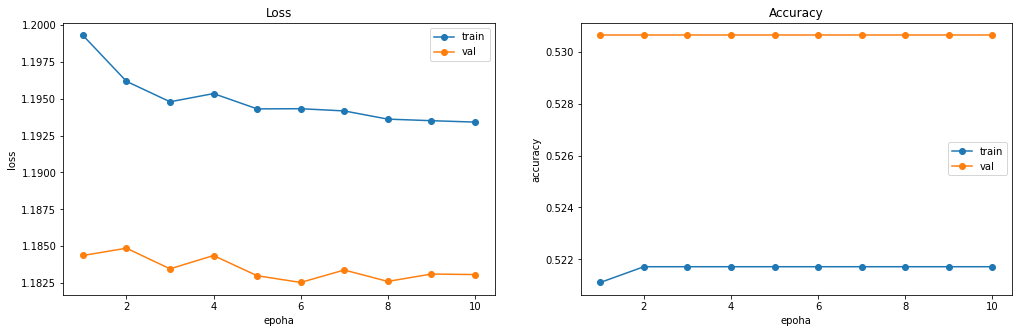

In [ ]:
plot_history(history_LSTM, br_epoha)

In [ ]:
batch_size=16
br_epoha=10
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/10
1648/1648 [==============================] - 20s 11ms/step - loss: 1.1990 - accuracy: 0.5213 - val_loss: 1.1839 - val_accuracy: 0.5306
Epoch 2/10
1648/1648 [==============================] - 19s 11ms/step - loss: 1.1959 - accuracy: 0.5217 - val_loss: 1.1839 - val_accuracy: 0.5306
Epoch 3/10
1648/1648 [==============================] - 17s 10ms/step - loss: 1.1980 - accuracy: 0.5215 - val_loss: 1.1827 - val_accuracy: 0.5306
Epoch 4/10
1648/1648 [==============================] - 17s 11ms/step - loss: 1.1944 - accuracy: 0.5217 - val_loss: 1.1848 - val_accuracy: 0.5306
Epoch 5/10
1648/1648 [==============================] - 19s 11ms/step - loss: 1.1937 - accuracy: 0.5217 - val_loss: 1.1843 - val_accuracy: 0.5306
Epoch 6/10
1648/1648 [==============================] - 17s 10ms/step - loss: 1.1944 - accuracy: 0.5217 - val_loss: 1.1825 - val_accuracy: 0.5306
Epoch 7/10
1648/1648 [==============================] - 17s 10ms/step - loss: 1.1936 - accuracy: 0.5217 - val_loss: 1.1828 -

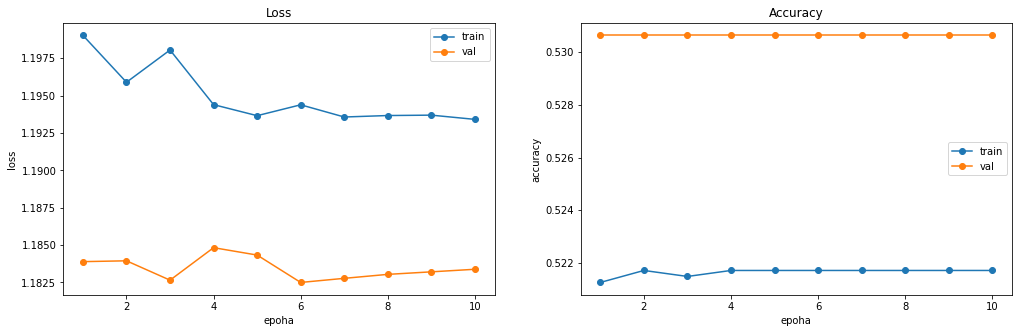

In [ ]:
plot_history(history_LSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=20
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/20
206/206 [==============================] - 2s 12ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 2.8133 - val_accuracy: 0.6490
Epoch 2/20
206/206 [==============================] - 3s 14ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 3.1285 - val_accuracy: 0.6508
Epoch 3/20
206/206 [==============================] - 3s 12ms/step - loss: 8.2289e-04 - accuracy: 0.9995 - val_loss: 2.7675 - val_accuracy: 0.6517
Epoch 4/20
206/206 [==============================] - 3s 13ms/step - loss: 7.1899e-04 - accuracy: 0.9996 - val_loss: 2.9199 - val_accuracy: 0.6546
Epoch 5/20
206/206 [==============================] - 2s 12ms/step - loss: 7.5084e-04 - accuracy: 0.9995 - val_loss: 2.9810 - val_accuracy: 0.6532
Epoch 6/20
206/206 [==============================] - 3s 12ms/step - loss: 7.3977e-04 - accuracy: 0.9995 - val_loss: 3.0308 - val_accuracy: 0.6523
Epoch 7/20
206/206 [==============================] - 3s 15ms/step - loss: 6.4037e-04 - accuracy: 0.9996 - val_loss: 3.0780 - 

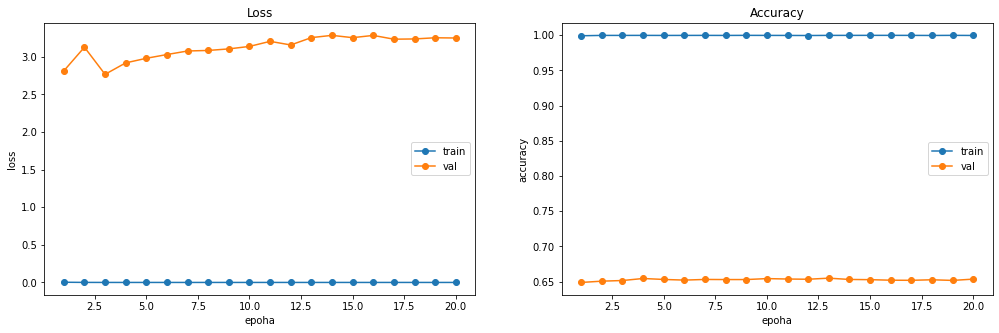

In [ ]:
plot_history(history_LSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=30
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/30
206/206 [==============================] - 3s 13ms/step - loss: 7.2317e-04 - accuracy: 0.9996 - val_loss: 3.1791 - val_accuracy: 0.6537
Epoch 2/30
206/206 [==============================] - 3s 14ms/step - loss: 6.5626e-04 - accuracy: 0.9995 - val_loss: 3.2569 - val_accuracy: 0.6532
Epoch 3/30
206/206 [==============================] - 3s 14ms/step - loss: 8.2993e-04 - accuracy: 0.9995 - val_loss: 3.5669 - val_accuracy: 0.6494
Epoch 4/30
206/206 [==============================] - 2s 12ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 3.1036 - val_accuracy: 0.6535
Epoch 5/30
206/206 [==============================] - 3s 13ms/step - loss: 6.8539e-04 - accuracy: 0.9996 - val_loss: 3.2521 - val_accuracy: 0.6585
Epoch 6/30
206/206 [==============================] - 2s 12ms/step - loss: 6.8120e-04 - accuracy: 0.9997 - val_loss: 3.3554 - val_accuracy: 0.6578
Epoch 7/30
206/206 [==============================] - 2s 12ms/step - loss: 6.2802e-04 - accuracy: 0.9995 - val_loss: 3.380

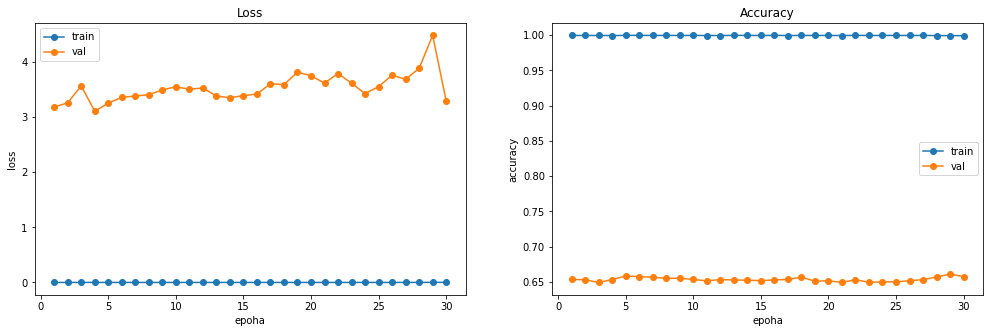

In [ ]:
plot_history(history_LSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=40
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/40
206/206 [==============================] - 3s 13ms/step - loss: 7.6085e-04 - accuracy: 0.9995 - val_loss: 3.3314 - val_accuracy: 0.6585
Epoch 2/40
206/206 [==============================] - 3s 12ms/step - loss: 7.1190e-04 - accuracy: 0.9996 - val_loss: 3.3536 - val_accuracy: 0.6591
Epoch 3/40
206/206 [==============================] - 4s 20ms/step - loss: 7.7074e-04 - accuracy: 0.9995 - val_loss: 3.3845 - val_accuracy: 0.6593
Epoch 4/40
206/206 [==============================] - 2s 11ms/step - loss: 6.6888e-04 - accuracy: 0.9996 - val_loss: 3.3923 - val_accuracy: 0.6590
Epoch 5/40
206/206 [==============================] - 3s 14ms/step - loss: 6.2242e-04 - accuracy: 0.9997 - val_loss: 3.4463 - val_accuracy: 0.6593
Epoch 6/40
206/206 [==============================] - 3s 13ms/step - loss: 7.2931e-04 - accuracy: 0.9995 - val_loss: 3.4793 - val_accuracy: 0.6606
Epoch 7/40
206/206 [==============================] - 3s 12ms/step - loss: 6.2747e-04 - accuracy: 0.9996 - val_loss: 3

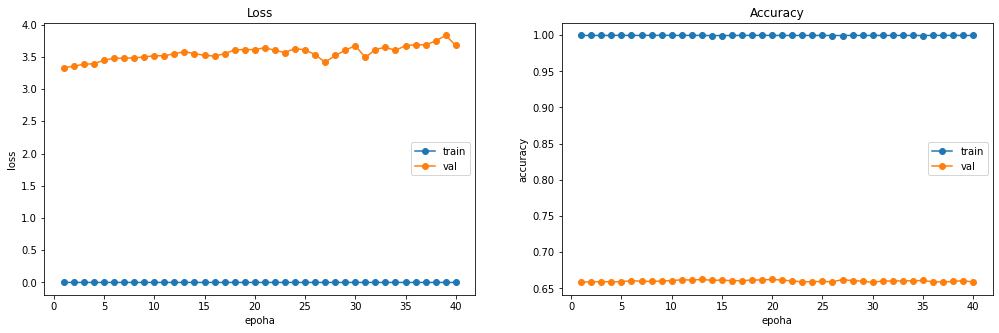

In [ ]:
plot_history(history_LSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=50
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/50
206/206 [==============================] - 3s 13ms/step - loss: 7.9757e-04 - accuracy: 0.9995 - val_loss: 3.4605 - val_accuracy: 0.6608
Epoch 2/50
206/206 [==============================] - 3s 14ms/step - loss: 7.7580e-04 - accuracy: 0.9995 - val_loss: 3.7794 - val_accuracy: 0.6581
Epoch 3/50
206/206 [==============================] - 2s 12ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 2.3460 - val_accuracy: 0.6450
Epoch 4/50
206/206 [==============================] - 2s 12ms/step - loss: 0.0023 - accuracy: 0.9991 - val_loss: 1.9767 - val_accuracy: 0.6459
Epoch 5/50
206/206 [==============================] - 3s 15ms/step - loss: 8.7640e-04 - accuracy: 0.9996 - val_loss: 2.4795 - val_accuracy: 0.6505
Epoch 6/50
206/206 [==============================] - 3s 13ms/step - loss: 9.1480e-04 - accuracy: 0.9995 - val_loss: 2.5093 - val_accuracy: 0.6452
Epoch 7/50
206/206 [==============================] - 3s 15ms/step - loss: 7.0068e-04 - accuracy: 0.9996 - val_loss: 2.5427 - 

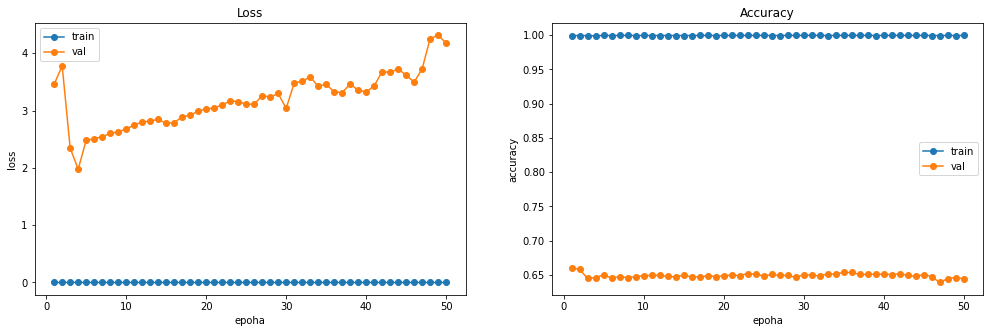

In [ ]:
plot_history(history_LSTM, br_epoha)

Isprobavanjem različitih hiperparametara i višestrukim pokretanjem dobiju se najbolji rezultati za batch size 128 i 30 epoha. Za batch size 64 overfitting se pojavljuje tek napola treniranja, točnost je iznad 65%, a gubitak na skupu za validaciju je niži naspram gubitka za neki drugi batch size. Treniranje u 30 epoha daje najveću točnost uz najmanji gubitak u usporedbi s drugim mogućim brojevima epoha. Pokušajmo istrenirati i evaluirati mrežu za oba dobivena najbolja parametra.

In [ ]:
batch_size=128
br_epoha=30
history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_LSTM)

Epoch 1/30
206/206 [==============================] - 7s 15ms/step - loss: 1.2003 - accuracy: 0.5198 - val_loss: 1.1841 - val_accuracy: 0.5306
Epoch 2/30
206/206 [==============================] - 2s 12ms/step - loss: 1.1961 - accuracy: 0.5217 - val_loss: 1.1840 - val_accuracy: 0.5306
Epoch 3/30
206/206 [==============================] - 2s 12ms/step - loss: 1.1761 - accuracy: 0.5241 - val_loss: 1.0393 - val_accuracy: 0.5812
Epoch 4/30
206/206 [==============================] - 3s 15ms/step - loss: 0.9628 - accuracy: 0.6178 - val_loss: 0.9786 - val_accuracy: 0.6259
Epoch 5/30
206/206 [==============================] - 2s 12ms/step - loss: 0.6341 - accuracy: 0.7642 - val_loss: 1.0148 - val_accuracy: 0.6277
Epoch 6/30
206/206 [==============================] - 2s 12ms/step - loss: 0.3128 - accuracy: 0.8921 - val_loss: 1.5590 - val_accuracy: 0.5334
Epoch 7/30
206/206 [==============================] - 2s 12ms/step - loss: 0.1618 - accuracy: 0.9503 - val_loss: 1.2269 - val_accuracy: 0.5931

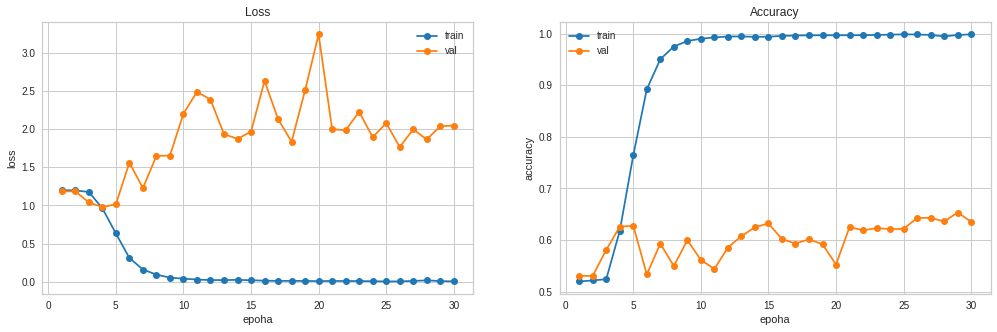

In [ ]:
plot_history(history_LSTM, br_epoha)

Treniranjem i evaluacijom LSTM modela za batch size 128 i 30 epoha dobije se točnost od oko 63% na skupu za testiranje, što je solidno u odnosu na ostale dobivane točnosti. Iako ta točnost nije maksimalna moguća među onima koje smo dobivali, za ove parametre postiže se najmanji mogući gubitak i do overfittinga dolazi nakon 6-7 epoha, što je kasnije nego kod većine ostalih modela, a moglo bi se možda dodatno popraviti regularizacijom u obliku early stoppinga.

**Regularizacija koristeći early stopping**

In [ ]:
# zaustavljamo treniranje mreže ako 3 uzastopne epohe nema poboljšanja gubitka na skupu za validaciju
callback_ES_LSTM = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_ES_LSTM = model_LSTM
hist_es_LSTM = model_ES_LSTM.fit(X_train, y_train, epochs=br_epoha, batch_size=batch_size, validation_split=0.2,
             callbacks=[callback_ES_LSTM])

Epoch 1/30
206/206 [==============================] - 5s 17ms/step - loss: 1.2014 - accuracy: 0.5199 - val_loss: 1.1860 - val_accuracy: 0.5306
Epoch 2/30
206/206 [==============================] - 3s 13ms/step - loss: 1.1953 - accuracy: 0.5217 - val_loss: 1.1830 - val_accuracy: 0.5306
Epoch 3/30
206/206 [==============================] - 3s 12ms/step - loss: 1.1951 - accuracy: 0.5217 - val_loss: 1.1846 - val_accuracy: 0.5306
Epoch 4/30
206/206 [==============================] - 2s 12ms/step - loss: 1.1946 - accuracy: 0.5217 - val_loss: 1.1832 - val_accuracy: 0.5306
Epoch 5/30
206/206 [==============================] - 2s 12ms/step - loss: 1.1949 - accuracy: 0.5215 - val_loss: 1.1642 - val_accuracy: 0.5306
Epoch 6/30
206/206 [==============================] - 3s 14ms/step - loss: 1.1279 - accuracy: 0.5349 - val_loss: 1.1509 - val_accuracy: 0.5358
Epoch 7/30
206/206 [==============================] - 3s 14ms/step - loss: 1.0015 - accuracy: 0.5671 - val_loss: 0.9975 - val_accuracy: 0.5667

In [ ]:
print('Early Stopping:')
print_acc(model_ES_LSTM)
# visa tocnost nakon primjene early stopping

Early Stopping:
Accuracy on test data: 67.37 %


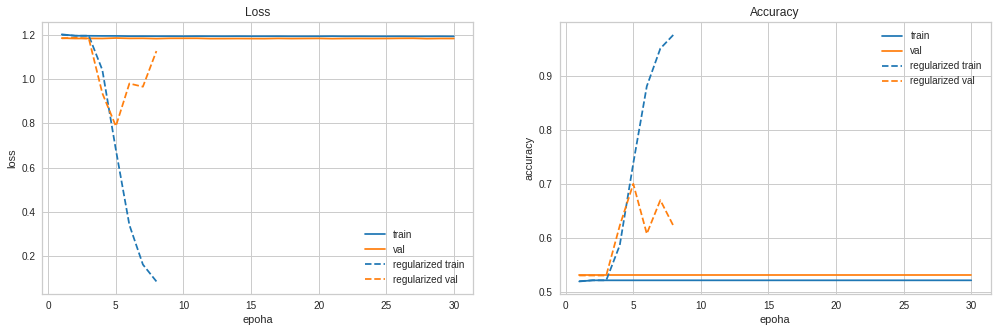

In [ ]:
plot_history2(history_LSTM, hist_es_LSTM)

Korištenjem early stoppinga, treniranje se završilo nakon prvih 7 epoha, odnosno dok je postojalo poboljšanje gubitka na skupu za validaciju. Kao rezultat toga, gubitak na skupu za treniranje smanjen je na 0, a točnost na skupu za treniranje povećana na 100%. Na skupu za validaciju ne mogu se postići toliko dobri rezultati, ali ukupna točnost na skupu za testiranje je veća nego bez regularizacije i sada iznosi oko 67% i osim toga točnost je dosta stabilnija i bez velikih oscilacija u odnosu na točnost prije uvođenja regularizacije.

Pokušamo primijeniti early stopping ali umjesto promatranja gubitka na skupu za validaciju pratimo poboljšanje točnosti na skupu za validaciju.

In [ ]:
callback_ES_LSTM2 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# zaustavljamo treniranje ako se u 3 uzastopne epohe ne poboljša točnost na skupu za validaciju

model_ES_LSTM2 = model_LSTM
hist_es_LSTM2 = model_ES_LSTM.fit(X_train, y_train, epochs=br_epoha, batch_size=batch_size, validation_split=0.2,
             callbacks=[callback_ES_LSTM2])

Epoch 1/30
206/206 [==============================] - 3s 13ms/step - loss: 0.0696 - accuracy: 0.9841 - val_loss: 1.7664 - val_accuracy: 0.6496
Epoch 2/30
206/206 [==============================] - 2s 12ms/step - loss: 0.0582 - accuracy: 0.9860 - val_loss: 1.3808 - val_accuracy: 0.6822
Epoch 3/30
206/206 [==============================] - 3s 14ms/step - loss: 0.0480 - accuracy: 0.9887 - val_loss: 1.5280 - val_accuracy: 0.6532
Epoch 4/30
206/206 [==============================] - 3s 14ms/step - loss: 0.0393 - accuracy: 0.9904 - val_loss: 1.5798 - val_accuracy: 0.6538
Epoch 5/30
206/206 [==============================] - 2s 12ms/step - loss: 0.0341 - accuracy: 0.9914 - val_loss: 1.5256 - val_accuracy: 0.6531


In [ ]:
print('Early Stopping:')
print_acc(model_ES_LSTM2)

Early Stopping:
Accuracy on test data: 51.97 %


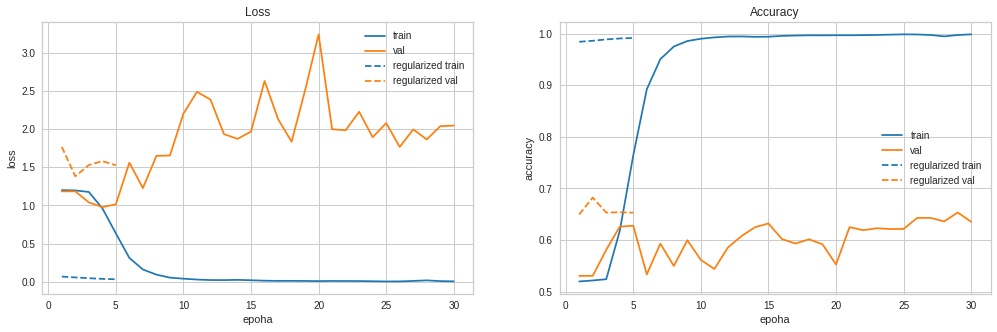

In [ ]:
plot_history2(history_LSTM, hist_es_LSTM2)

####**GRU**

In [ ]:
batch_size=128
br_epoha=30

In [ ]:
model_GRU=Sequential()
model_GRU.add(Embedding(input_dim=vocab_size,
                    output_dim=128,
                    input_length=max_len))
model_GRU.add(GRU(128, activation='tanh',
                  return_sequences=False))
model_GRU.add(Dropout(0.3))
model_GRU.add(Dense(4, activation='softmax'))
#cp = ModelCheckpoint('model_GRU/', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') #dodamo checkpoint


model_GRU.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 46, 128)           8584192   
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 8,683,780
Trainable params: 8,683,780
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_GRU = model_GRU.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/30
206/206 [==============================] - 5s 14ms/step - loss: 1.2029 - accuracy: 0.5200 - val_loss: 1.1901 - val_accuracy: 0.5306
Epoch 2/30
206/206 [==============================] - 2s 11ms/step - loss: 1.1959 - accuracy: 0.5217 - val_loss: 1.1837 - val_accuracy: 0.5306
Epoch 3/30
206/206 [==============================] - 3s 14ms/step - loss: 1.1958 - accuracy: 0.5217 - val_loss: 1.1845 - val_accuracy: 0.5306
Epoch 4/30
206/206 [==============================] - 2s 11ms/step - loss: 1.1953 - accuracy: 0.5217 - val_loss: 1.1826 - val_accuracy: 0.5306
Epoch 5/30
206/206 [==============================] - 2s 12ms/step - loss: 1.1946 - accuracy: 0.5217 - val_loss: 1.1834 - val_accuracy: 0.5306
Epoch 6/30
206/206 [==============================] - 2s 11ms/step - loss: 1.1944 - accuracy: 0.5217 - val_loss: 1.1829 - val_accuracy: 0.5306
Epoch 7/30
206/206 [==============================] - 2s 11ms/step - loss: 1.1948 - accuracy: 0.5217 - val_loss: 1.1836 - val_accuracy: 0.5306

In [ ]:
print_acc(model_GRU)

Accuracy on test data: 51.97 %


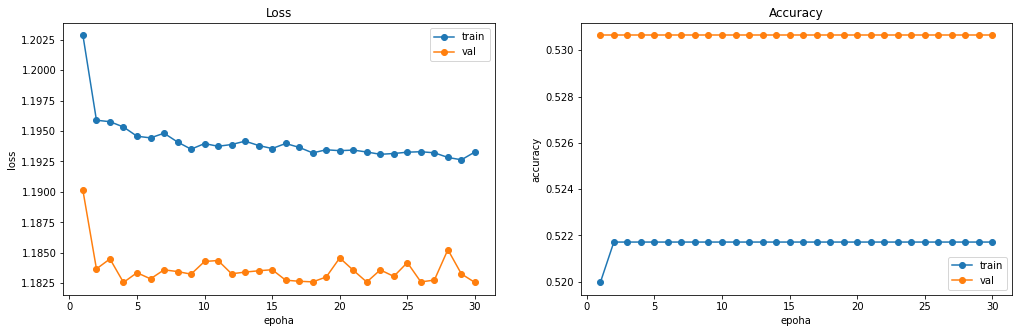

In [ ]:
plot_history(history_GRU, br_epoha)

Kako god promijenili dropout size ili batch size ili broj epoha, uvijek se dobiva isti val_accuracy u iznosu 0.5306 i toliko iznosi u svim epohama, i isti test accuracy 51.97%. Krivulja za funkciju gubitka pokazuje rast i pad no uglavnom se kreće oko 1.1, dok je krivulja za točnost pravac paralelan s osi x i ima konstantnu vrijednost kroz sve epohe.

Iako je GRU model unapređenje SimpleRNN-a i radi brže od SimpleRNN-a i LSTM-a, na ovom skupu podataka ima manju točnost nego ta dva modela i nije se pokazao puno boljim. Na nekim skupovima podataka GRU zna dati puno veću točnost u odnosu na druge modele, međutim na ovom skupu podataka već iz krivulje točnosti koja je horizontalni pravac možemo naslutiti da je GRU model dosegao svoju maksimalnu točnost i ne može puno bolje raditi ni uz promjenu hiperparametara.

####**Bidirectional LSTM**

**Treniranje i evaluacija**

Za različite dropout rates 0.2, 0.3, 0.4, 0.5 redom, dobiju se otprilike sljedeće točnosti na skupu za testiranje: 60.11%, 67.23%, 66.50%, 66.26%. Zbog toga sam izabrala dropout rate 0.3 jer daje najbolje rezultate.

In [ ]:
model_BiLSTM=Sequential()
model_BiLSTM.add(Embedding(input_dim=vocab_size,
                    output_dim=128,
                    input_length=max_len))
model_BiLSTM.add(Bidirectional(LSTM(128))) #ovo smo dodali (bez toga bi bila obicna RNN)
model_BiLSTM.add(Dropout(0.3))   #dropout sloj (naknadno)
model_BiLSTM.add(Dense(4, activation='softmax'))
#cp = ModelCheckpoint('model_BiLSTM', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') #dodamo checkpoint
model_BiLSTM.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_BiLSTM.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 46, 128)           8584192   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 8,848,388
Trainable params: 8,848,388
Non-trainable params: 0
_________________________________________________________________


In [ ]:
br_epoha=10
batch_size=128

In [ ]:
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/10
206/206 [==============================] - 7s 19ms/step - loss: 0.9199 - accuracy: 0.6237 - val_loss: 0.7599 - val_accuracy: 0.7015
Epoch 2/10
206/206 [==============================] - 3s 15ms/step - loss: 0.5112 - accuracy: 0.8064 - val_loss: 0.7405 - val_accuracy: 0.7227
Epoch 3/10
206/206 [==============================] - 4s 19ms/step - loss: 0.1913 - accuracy: 0.9337 - val_loss: 0.9714 - val_accuracy: 0.6978
Epoch 4/10
206/206 [==============================] - 4s 17ms/step - loss: 0.0730 - accuracy: 0.9765 - val_loss: 1.1677 - val_accuracy: 0.6993
Epoch 5/10
206/206 [==============================] - 3s 16ms/step - loss: 0.0380 - accuracy: 0.9888 - val_loss: 1.3743 - val_accuracy: 0.6713
Epoch 6/10
206/206 [==============================] - 3s 16ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 1.5380 - val_accuracy: 0.6411
Epoch 7/10
206/206 [==============================] - 4s 19ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 1.6421 - val_accuracy: 0.6632

In [ ]:
print_acc(model_BiLSTM)

Accuracy on test data: 67.33 %


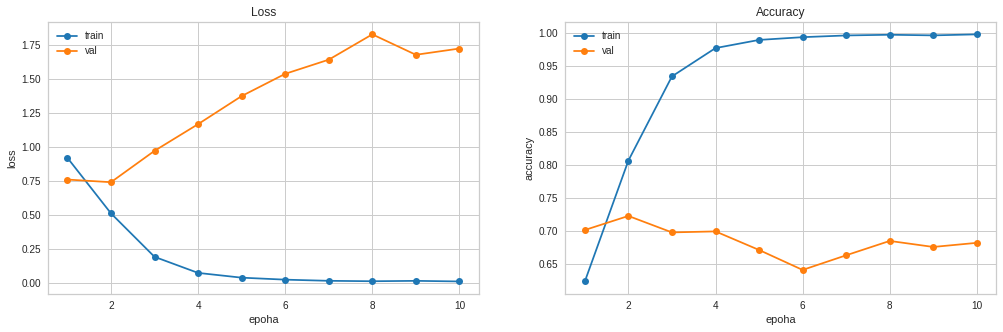

In [ ]:
plot_history(history_BiLSTM, br_epoha)

Idalje je prisutan overfitting, ali se postiže veća točnost na skupu za validaciju (ovdje iznosi oko 72%) u odnosu na prethodne modele. Točnost modela na skupu za validaciju dosta je stabilna i ne pokazuje naglo padanje, kreće se oko 70%. Iz checkpointa vidimo da ja najveća točnost postignuta na skupu za validaciju jednaka 71%.

Iako često daju vrlo slične rezultate, većinu puta kad sam pokrenula treniranje, Bidirectional LSTM model dao je bolje rezultate od običnog LSTM, što sam i očekivala jer Bidirectional LSTM uglavnom ima bolju izvedbu.

**Predviđanje na skupu za testiranje i matrica konfuzije**

In [ ]:
predvideni=model_BiLSTM.predict(X_test, verbose=1)

344/344 [==============================] - 1s 4ms/step


In [ ]:
predvideni=[np.argmax(x) for x in predvideni]

Text(0.5, 1.0, 'Predviđanje Bidirectional LSTM modelom')

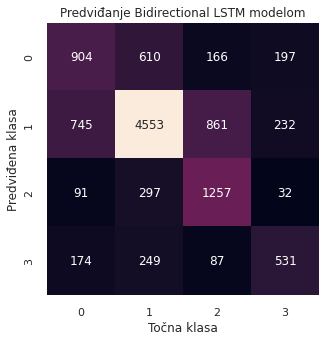

In [ ]:
mat_BiLSTM = confusion_matrix(y_test, predvideni)
plt.figure(figsize = (5,5))
sns.set(font_scale=1) # malo veći font
sns.heatmap(mat_BiLSTM.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Točna klasa')
plt.ylabel('Predviđena klasa')
plt.title('Predviđanje Bidirectional LSTM modelom')

In [ ]:
# koliko ih je tocno razvrstanih (odn. dijagonalnih)
ukupno=len(y_test)
tocno=mat_BiLSTM[0][0]+mat_BiLSTM[1][1]+mat_BiLSTM[2][2]+mat_BiLSTM[3][3]
print("Tocno razvrstanih je {:.2f} ".format(tocno/ukupno))

Tocno razvrstanih je 0.66 


Matrica konfuzije ovog modela ima više dijagonalnih elemenata nego matrica konfuzije LSTM modela s dropoutom pa, osim iz bolje točnosti, i iz ovoga možemo zaključiti da je dvosmjerni LSTM model bolji od običnog LSTM modela.

**Prikaz netočno klasificiranih primjera iz skupa za testiranje**

In [ ]:
predvideni[:10] #prvih 10 predviđanja

[1, 1, 1, 1, 1, 3, 1, 1, 2, 1]

In [ ]:
# krivo klasificirani
krivo = [tekst  for (tekst, pred, labela) in zip(X_test, predvideni, y_test) if predvideni != labela]

print(krivo[0]) #zanima nas koje su ovo rijeci

[   13  7988  1342    20   964  1280   586     2     3    22    23 11597
    32   350     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]


In [ ]:
tocne_vrij=np.array(y_test)
print(tocne_vrij) # y_test pretvoren u niz za lakse pristupanje elementima

[1 1 1 ... 2 1 2]


In [ ]:
# prvih 10 krivo klasificiranih tweetova zajedno s njihovim predviđenim i stvarnim klasama

br=0
for i in range(len(tocne_vrij)):
  if predvideni[i]!=tocne_vrij[i]: #ako je primjer krivo klasificiran
    br+=1
    if br<10: #ogranicenje da printamo samo prvih 10 krivo klasificiranih
      recenica=""
      for x in krivo[br]: #krivo klasificiranu recenicu prevodimo iz brojeva u rijeci
        if x!=0:
          recenica+=list(token_index.keys())[list(token_index.values()).index(x)]+" "
      print(br,".primjer: {}. Predviđeno: {}, točno: {}.".format(recenica, predvideni[i], tocne_vrij[i]))


1 .primjer: nycsouthpaw seagal lori admit climat chang insist wall built . Predviđeno: 0, točno: 1.
2 .primjer: rt wef cleverest countri climat chang learn http co q74byermpv apoliticalco http co iprã . Predviđeno: 1, točno: 0.
3 .primjer: rt somexlcan listen barack obama discuss climat chang make miss common sens cri http co edo9dixuzq . Predviđeno: 1, točno: 2.
4 .primjer: nytim request presid america posit climat chang . Predviđeno: 0, točno: 1.
5 .primjer: rt stevesgoddard climat scientist depend global warm scam research fund keep becom unemploy would anyâ . Predviđeno: 1, točno: 2.
6 .primjer: rt sethmacfarlan look america offici believ climat chang hoax sorri everybodi els . Predviđeno: 0, točno: 1.
7 .primjer: rt ezraklein donald trump tweet climat chang skeptic time http co te79u3uojj . Predviđeno: 1, točno: 3.
8 .primjer: rt feraliaga link climat chang diabet http co do5u5rkywu http co zh4y9fyo1i . Predviđeno: 1, točno: 2.
9 .primjer: rt siddarthpaim head epa made anoth dange

**Prilagođavanje hiperparametara**

In [ ]:
batch_size=64
br_epoha=10
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/10
412/412 [==============================] - 11s 19ms/step - loss: 0.8650 - accuracy: 0.6451 - val_loss: 0.7196 - val_accuracy: 0.7072
Epoch 2/10
412/412 [==============================] - 6s 15ms/step - loss: 0.4374 - accuracy: 0.8363 - val_loss: 0.7680 - val_accuracy: 0.7162
Epoch 3/10
412/412 [==============================] - 7s 17ms/step - loss: 0.1318 - accuracy: 0.9562 - val_loss: 0.9845 - val_accuracy: 0.7013
Epoch 4/10
412/412 [==============================] - 6s 15ms/step - loss: 0.0507 - accuracy: 0.9832 - val_loss: 1.4122 - val_accuracy: 0.6725
Epoch 5/10
412/412 [==============================] - 7s 17ms/step - loss: 0.0295 - accuracy: 0.9911 - val_loss: 1.3595 - val_accuracy: 0.6889
Epoch 6/10
412/412 [==============================] - 7s 16ms/step - loss: 0.0227 - accuracy: 0.9936 - val_loss: 1.5006 - val_accuracy: 0.6826
Epoch 7/10
412/412 [==============================] - 7s 17ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 1.5628 - val_accuracy: 0.678

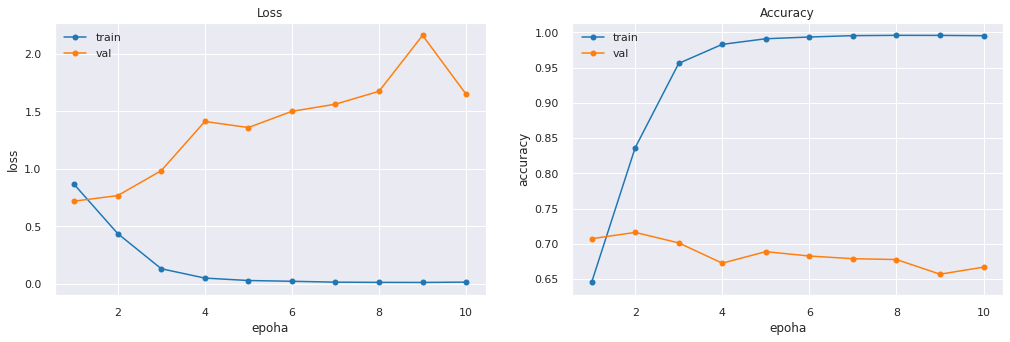

In [ ]:
plot_history(history_BiLSTM, br_epoha)

In [ ]:
batch_size=32
br_epoha=10
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/10
824/824 [==============================] - 17s 17ms/step - loss: 0.8310 - accuracy: 0.6604 - val_loss: 0.6949 - val_accuracy: 0.7286
Epoch 2/10
824/824 [==============================] - 13s 16ms/step - loss: 0.3645 - accuracy: 0.8665 - val_loss: 0.8878 - val_accuracy: 0.6787
Epoch 3/10
824/824 [==============================] - 13s 16ms/step - loss: 0.1059 - accuracy: 0.9647 - val_loss: 0.9418 - val_accuracy: 0.6986
Epoch 4/10
824/824 [==============================] - 13s 16ms/step - loss: 0.0482 - accuracy: 0.9844 - val_loss: 1.4347 - val_accuracy: 0.6235
Epoch 5/10
824/824 [==============================] - 13s 16ms/step - loss: 0.0270 - accuracy: 0.9917 - val_loss: 1.3262 - val_accuracy: 0.6828
Epoch 6/10
824/824 [==============================] - 13s 16ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 1.4325 - val_accuracy: 0.6808
Epoch 7/10
824/824 [==============================] - 13s 16ms/step - loss: 0.0185 - accuracy: 0.9943 - val_loss: 2.1297 - val_accuracy:

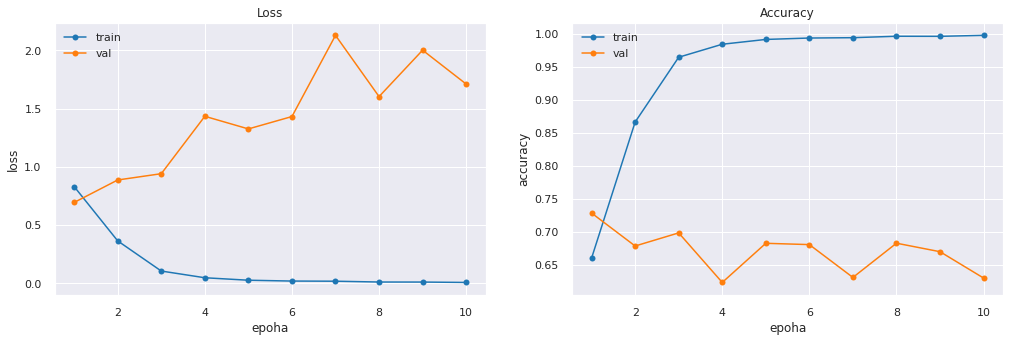

In [ ]:
plot_history(history_BiLSTM, br_epoha)

In [ ]:
batch_size=16
br_epoha=10
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/10
1648/1648 [==============================] - 28s 15ms/step - loss: 0.8182 - accuracy: 0.6693 - val_loss: 0.6837 - val_accuracy: 0.7263
Epoch 2/10
1648/1648 [==============================] - 24s 15ms/step - loss: 0.3265 - accuracy: 0.8827 - val_loss: 0.8212 - val_accuracy: 0.6975
Epoch 3/10
1648/1648 [==============================] - 24s 15ms/step - loss: 0.0914 - accuracy: 0.9705 - val_loss: 1.1546 - val_accuracy: 0.6593
Epoch 4/10
1648/1648 [==============================] - 27s 16ms/step - loss: 0.0420 - accuracy: 0.9859 - val_loss: 1.2713 - val_accuracy: 0.6740
Epoch 5/10
1648/1648 [==============================] - 24s 14ms/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 1.4519 - val_accuracy: 0.6575
Epoch 6/10
1648/1648 [==============================] - 23s 14ms/step - loss: 0.0154 - accuracy: 0.9951 - val_loss: 1.4870 - val_accuracy: 0.6588
Epoch 7/10
1648/1648 [==============================] - 24s 15ms/step - loss: 0.0116 - accuracy: 0.9966 - val_loss: 1.4253 -

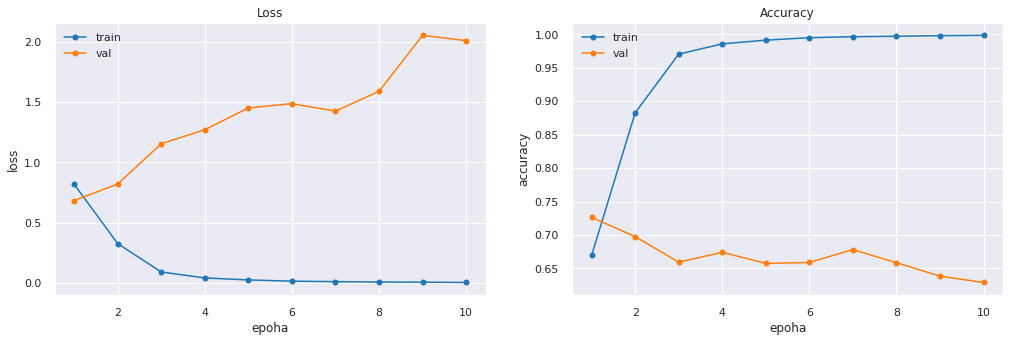

In [ ]:
plot_history(history_BiLSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=20
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/20
206/206 [==============================] - 8s 24ms/step - loss: 0.9203 - accuracy: 0.6202 - val_loss: 0.7517 - val_accuracy: 0.6880
Epoch 2/20
206/206 [==============================] - 3s 16ms/step - loss: 0.5260 - accuracy: 0.7983 - val_loss: 0.7121 - val_accuracy: 0.7263
Epoch 3/20
206/206 [==============================] - 3s 16ms/step - loss: 0.2139 - accuracy: 0.9260 - val_loss: 0.8848 - val_accuracy: 0.7112
Epoch 4/20
206/206 [==============================] - 4s 18ms/step - loss: 0.0755 - accuracy: 0.9764 - val_loss: 1.1078 - val_accuracy: 0.6889
Epoch 5/20
206/206 [==============================] - 4s 19ms/step - loss: 0.0365 - accuracy: 0.9892 - val_loss: 1.2951 - val_accuracy: 0.6875
Epoch 6/20
206/206 [==============================] - 3s 16ms/step - loss: 0.0233 - accuracy: 0.9929 - val_loss: 1.5682 - val_accuracy: 0.6795
Epoch 7/20
206/206 [==============================] - 3s 16ms/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 1.4716 - val_accuracy: 0.6877

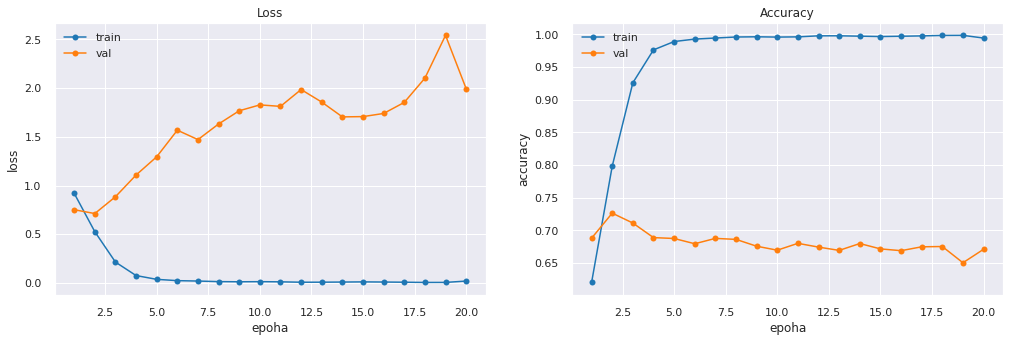

In [ ]:
plot_history(history_BiLSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=30
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/30
206/206 [==============================] - 7s 20ms/step - loss: 0.9308 - accuracy: 0.6195 - val_loss: 0.7288 - val_accuracy: 0.7084
Epoch 2/30
206/206 [==============================] - 4s 17ms/step - loss: 0.5069 - accuracy: 0.8069 - val_loss: 0.7189 - val_accuracy: 0.7235
Epoch 3/30
206/206 [==============================] - 4s 20ms/step - loss: 0.1906 - accuracy: 0.9357 - val_loss: 0.9833 - val_accuracy: 0.6828
Epoch 4/30
206/206 [==============================] - 3s 16ms/step - loss: 0.0692 - accuracy: 0.9785 - val_loss: 1.1121 - val_accuracy: 0.6948
Epoch 5/30
206/206 [==============================] - 3s 16ms/step - loss: 0.0342 - accuracy: 0.9897 - val_loss: 1.4103 - val_accuracy: 0.6538
Epoch 6/30
206/206 [==============================] - 4s 18ms/step - loss: 0.0215 - accuracy: 0.9939 - val_loss: 1.4886 - val_accuracy: 0.6453
Epoch 7/30
206/206 [==============================] - 4s 19ms/step - loss: 0.0164 - accuracy: 0.9956 - val_loss: 1.7727 - val_accuracy: 0.6650

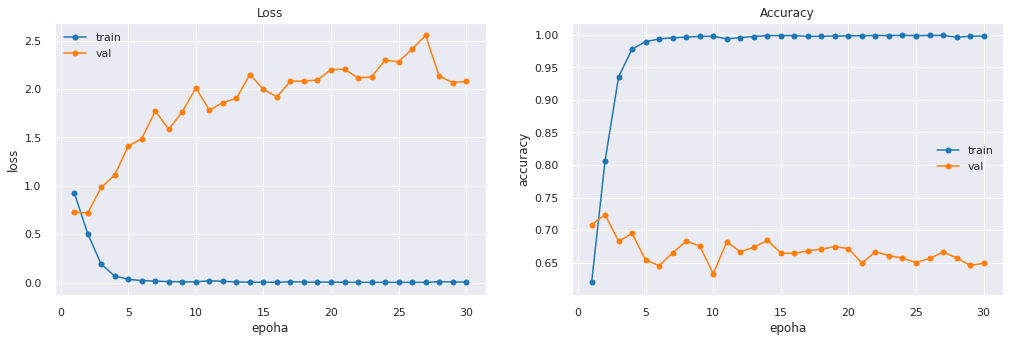

In [ ]:
plot_history(history_BiLSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=40
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/40
206/206 [==============================] - 9s 23ms/step - loss: 0.9331 - accuracy: 0.6144 - val_loss: 0.7451 - val_accuracy: 0.7084
Epoch 2/40
206/206 [==============================] - 4s 18ms/step - loss: 0.5064 - accuracy: 0.8106 - val_loss: 0.6991 - val_accuracy: 0.7224
Epoch 3/40
206/206 [==============================] - 3s 16ms/step - loss: 0.1925 - accuracy: 0.9360 - val_loss: 0.8729 - val_accuracy: 0.7119
Epoch 4/40
206/206 [==============================] - 3s 16ms/step - loss: 0.0702 - accuracy: 0.9782 - val_loss: 1.1392 - val_accuracy: 0.6883
Epoch 5/40
206/206 [==============================] - 4s 20ms/step - loss: 0.0325 - accuracy: 0.9904 - val_loss: 1.3973 - val_accuracy: 0.6851
Epoch 6/40
206/206 [==============================] - 4s 17ms/step - loss: 0.0201 - accuracy: 0.9942 - val_loss: 1.4900 - val_accuracy: 0.6519
Epoch 7/40
206/206 [==============================] - 3s 16ms/step - loss: 0.0162 - accuracy: 0.9958 - val_loss: 1.7808 - val_accuracy: 0.6878

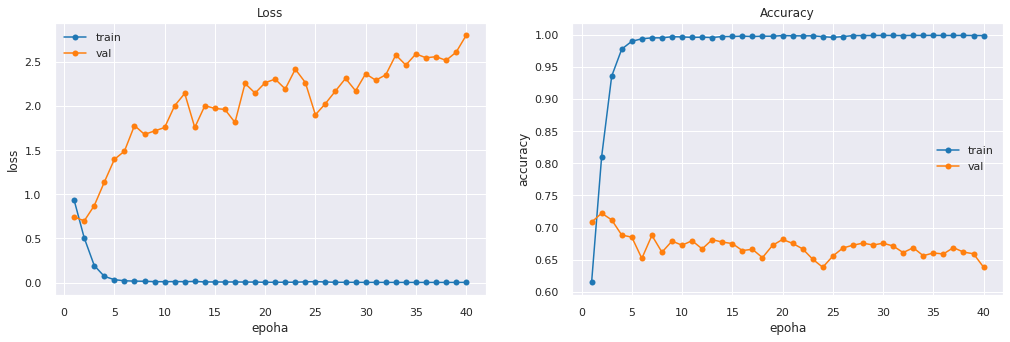

In [ ]:
plot_history(history_BiLSTM, br_epoha)

In [ ]:
batch_size=128
br_epoha=50
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/50
206/206 [==============================] - 7s 20ms/step - loss: 0.9102 - accuracy: 0.6292 - val_loss: 0.7444 - val_accuracy: 0.7008
Epoch 2/50
206/206 [==============================] - 3s 16ms/step - loss: 0.5008 - accuracy: 0.8102 - val_loss: 0.7317 - val_accuracy: 0.7247
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 0.1859 - accuracy: 0.9364 - val_loss: 0.9345 - val_accuracy: 0.6978
Epoch 4/50
206/206 [==============================] - 3s 16ms/step - loss: 0.0703 - accuracy: 0.9783 - val_loss: 1.1783 - val_accuracy: 0.6760
Epoch 5/50
206/206 [==============================] - 3s 16ms/step - loss: 0.0345 - accuracy: 0.9898 - val_loss: 1.4368 - val_accuracy: 0.6444
Epoch 6/50
206/206 [==============================] - 3s 16ms/step - loss: 0.0217 - accuracy: 0.9940 - val_loss: 1.4779 - val_accuracy: 0.6632
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 1.9362 - val_accuracy: 0.6453

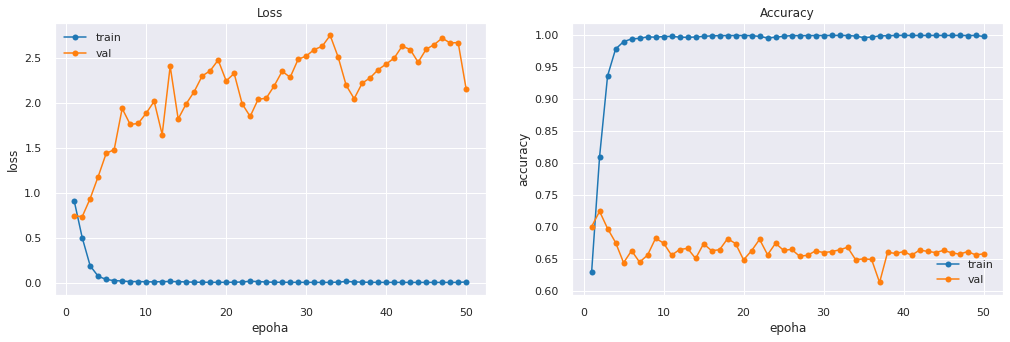

In [ ]:
plot_history(history_BiLSTM, br_epoha)

Isprobavanjem različitih hiperparametara i višestrukim pokretanjem dobiju se najbolji rezultati za batch size 64 i 20 epoha. Za batch size 64 overfitting se pojavljuje tek oko treće/četvrte epohe, točnost je često iznad 65%, a gubitak na skupu za validaciju je sporijeg je rasta naspram gubitka za ostale batch sizes. Treniranje u 20 epoha daje otprilike jednaku točnost ali uz najsporiji rast gubitka u usporedbi s drugim mogućim brojevima epoha. Naime, do desete epohe validation loss najsporije raste, za 20 epoha uočavam da validation loss značajno skoči tek u zadnje dvije epohe i točnost nema primjetan pad nego je dosta stabilna. Međutim za bilo koji veći broj epoha uočavamo da se uvijek nakon 10-15 epoha pojavljuje nagli rast validation lossa, a točnost za to vrijeme ostaje ista ili pada (za 50 epoha čak se u kasnijim epohama zna pojaviti i nagli pad točnosti) pa možemo zaključiti da je desetak odnosno dvadesetak epoha sasvim dovoljno za optimalno uvježbati mrežu. Pokušajmo istrenirati i evaluirati mrežu za oba dobivena najbolja parametra.

In [ ]:
batch_size=64
br_epoha=20
history_BiLSTM = model_BiLSTM.fit(X_train, y_train,
                    epochs=br_epoha,
                    batch_size=batch_size,
                    validation_split=0.2)
print_acc(model_BiLSTM)

Epoch 1/20
412/412 [==============================] - 11s 17ms/step - loss: 0.8588 - accuracy: 0.6498 - val_loss: 0.7059 - val_accuracy: 0.7198
Epoch 2/20
412/412 [==============================] - 7s 17ms/step - loss: 0.4374 - accuracy: 0.8395 - val_loss: 0.7576 - val_accuracy: 0.7154
Epoch 3/20
412/412 [==============================] - 6s 15ms/step - loss: 0.1402 - accuracy: 0.9526 - val_loss: 0.9451 - val_accuracy: 0.6801
Epoch 4/20
412/412 [==============================] - 8s 19ms/step - loss: 0.0527 - accuracy: 0.9838 - val_loss: 1.2278 - val_accuracy: 0.6638
Epoch 5/20
412/412 [==============================] - 6s 15ms/step - loss: 0.0297 - accuracy: 0.9915 - val_loss: 1.3050 - val_accuracy: 0.6473
Epoch 6/20
412/412 [==============================] - 7s 16ms/step - loss: 0.0212 - accuracy: 0.9939 - val_loss: 1.3956 - val_accuracy: 0.6757
Epoch 7/20
412/412 [==============================] - 6s 15ms/step - loss: 0.0141 - accuracy: 0.9961 - val_loss: 1.6249 - val_accuracy: 0.687

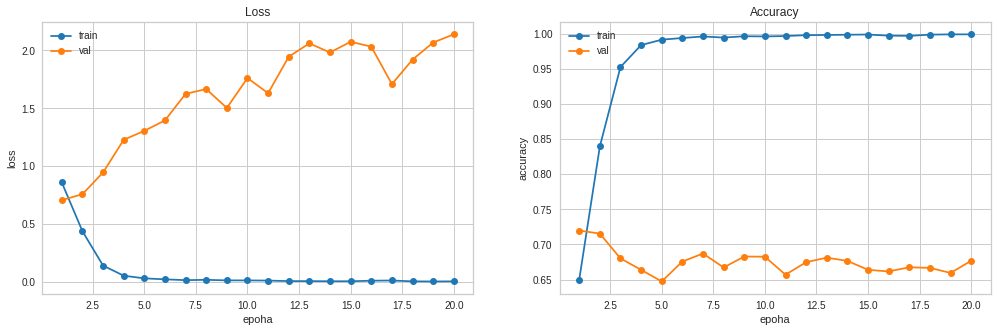

In [ ]:
plot_history(history_BiLSTM, br_epoha)

Treniranjem i evaluacijom LSTM modela za batch size 64 i 20 epoha dobije se točnost od oko 65% na skupu za testiranje, što spada među najveće točnosti dobivene variranjem hiperparametara. Također za ovaj izbor hiperparametara postiže se najsporiji mogući porast gubitka u odnosu na ostale modele, tek u posljednjim epohama pojavljuje se nagli porast. Overfitting je prisutan u svim modelima pa tako i u ovom ali se može pokušati ublažiti nekim metodama regularizacije, npr. early stoppingom.

**Regularizacija koristeći early stopping**

In [ ]:
# zaustavljamo treniranje mreže ako 3 uzastopne epohe nema poboljšanja gubitka na skupu za validaciju
callback_ES_BiLSTM = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_ES_BiLSTM = model_BiLSTM
hist_es_BiLSTM = model_ES_BiLSTM.fit(X_train, y_train, epochs=br_epoha, batch_size=batch_size, validation_split=0.2,
             callbacks=[callback_ES_BiLSTM])

Epoch 1/20
412/412 [==============================] - 11s 17ms/step - loss: 0.8653 - accuracy: 0.6440 - val_loss: 0.7112 - val_accuracy: 0.7235
Epoch 2/20
412/412 [==============================] - 7s 17ms/step - loss: 0.4192 - accuracy: 0.8472 - val_loss: 0.7889 - val_accuracy: 0.7148
Epoch 3/20
412/412 [==============================] - 6s 15ms/step - loss: 0.1309 - accuracy: 0.9563 - val_loss: 0.9484 - val_accuracy: 0.6925
Epoch 4/20
412/412 [==============================] - 7s 17ms/step - loss: 0.0521 - accuracy: 0.9837 - val_loss: 1.1598 - val_accuracy: 0.6778


In [ ]:
print('Early Stopping:')
print_acc(model_ES_BiLSTM)
# visa tocnost na skupu za testiranje nakon regularizacije koristeci early stopping

Early Stopping:
Accuracy on test data: 71.24 %


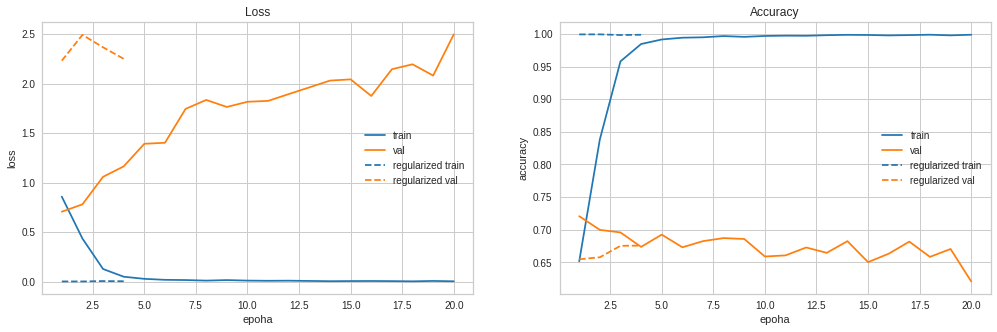

In [ ]:
plot_history2(history_BiLSTM, hist_es_BiLSTM)

Višestrukim pokretanjem regulariziranog modela uočavamo veću točnost na skupu za testiranje. Iz grafova vidimo da regularizirani model ima gubitak na skupu za treniranje smanjen na 0, dok gubitak na skupu za testiranje zna ispasti i veći nego bez regularizacije, no to je nadoknađeno boljom i stabilnijom točnošću na skupu za validaciju, koja ne pokazuje nagle padove. Očekvani, točnost regulariziranog modela na skupu za treniranje je 100%.

Primijenimo early stopping ali ovaj put tako da umjesto gubitka na skupu za validaciju promatramo poboljšanje točnosti na skupu za validaciju.

In [ ]:
callback_ES_BiLSTM2 = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

model_ES_BiLSTM2 = model_BiLSTM
hist_es_BiLSTM2 = model_ES_BiLSTM2.fit(X_train, y_train, epochs=br_epoha, batch_size=batch_size, validation_split=0.2,
             callbacks=[callback_ES_BiLSTM2])

Epoch 1/20
412/412 [==============================] - 11s 19ms/step - loss: 0.8697 - accuracy: 0.6423 - val_loss: 0.7615 - val_accuracy: 0.6992
Epoch 2/20
412/412 [==============================] - 7s 17ms/step - loss: 0.4346 - accuracy: 0.8384 - val_loss: 0.8026 - val_accuracy: 0.7005
Epoch 3/20
412/412 [==============================] - 7s 17ms/step - loss: 0.1343 - accuracy: 0.9552 - val_loss: 1.0461 - val_accuracy: 0.6562
Epoch 4/20
412/412 [==============================] - 6s 14ms/step - loss: 0.0542 - accuracy: 0.9831 - val_loss: 1.1680 - val_accuracy: 0.6849
Epoch 5/20
412/412 [==============================] - 7s 17ms/step - loss: 0.0295 - accuracy: 0.9909 - val_loss: 1.5525 - val_accuracy: 0.6848


In [ ]:
print('Early Stopping:')
print_acc(model_ES_BiLSTM2)

Early Stopping:
Accuracy on test data: 70.18 %


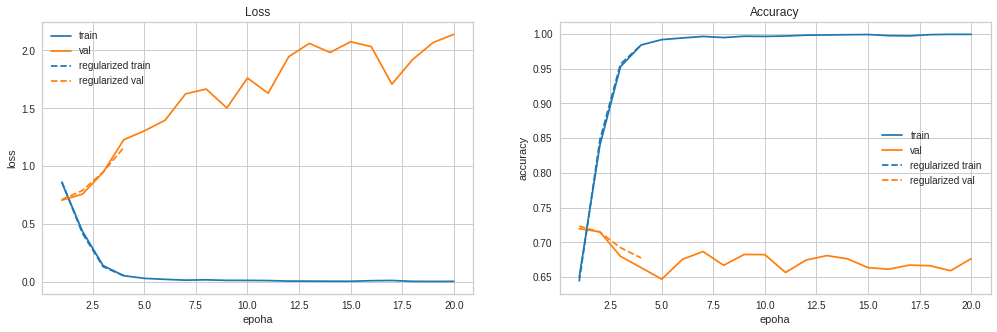

In [ ]:
plot_history2(history_BiLSTM, hist_es_BiLSTM)

Ovakvim oblikom early stoppinga postiže se smanjivanje gubitka na skupu za treniranje na 0, dok se točnost na skupu za treniranje povećava na 100%. No osim toga, bitniji rezultat je promjena točnosti na skupu za validaciju, iako npr. prilikom ovog pokretanja dobivamo ukupno malo nižu točnost, postignuta je veća stabilnost i nema naglih padova, čime se poboljšava izvođenje ovako regulariziranog modela.

### Usporedba LSTM i Bidirectional LSTM modela

S obzirom na točnost na skupu za testiranje, od ova četiri modela najboljima su se pokazali LSTM i Bidirectional LSTM pa sam njih detaljnije analizirala, provela predviđanje na skupu za testiranje, prikazala greške u klasifikaciji, prilagodila hiperparametre i regularizirala ih pomoću early stoppinga. Višestrukim pokretanjem ovih modela dobiju se uglavnom ovakve točnosti:

model | 10 epoha, batch size 128 | odabrani najbolji hiperparametri | regularizacija val_loss | regularizacija val_acc
--- | --- | --- | --- | ---
LSTM | 51.97% | 63.17% | 67.37% | 51.97%
BiLSTM | 67.33% | 66.29% | 71.24% | 70.18%

Čak i uz različit izbor parametara i regularizaciju, Bidirectional LSTM pokazao se uspješnijim od LSTM i gotovo uvijek ima višu točnost. Otprilike ovakav rezultat sam i očekivala jer je Bidirectional LSTM unapređenje LSTM modela i u većini slučajeva daje bolje rezultate.